# Model analisis sentimen ulasan aplikasi Shopee - Kelompok 6

Melakukan import library yang dibutuhkan untuk keseluruhan proyek.

In [ ]:
!pip install Sastrawi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load Dataset

In [ ]:
# Read dataset
data = pd.read_csv('/content/shopee_reviews.csv')

In [ ]:
# Menampilkan lima data teratas.
data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,5f18ebb3-0ac9-4975-a42a-829e1d1ac082,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,mantap kak,5,0,3.46.37,2025-03-24 07:55:25,"Hai kak Rian Riansyah, makasih ya buat apresiasi kamu udh review dan kasih full star utk Shopee. yuk tingkatin terus pembelanjaan kamu dan jangan lupa pantengin terus updatean Shopee di sosmed resmi Shopee biar kamu ga ketinggalan update promo seru dari Shopee. Have a nice day ^PD",2025-03-24 08:18:05,3.46.37
1,8e3e5261-e4cc-403f-adee-c084297d0cb6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,the best lah🤙🏼,5,0,3.45.60,2025-03-24 07:54:10,"Hai kak Richo putra , makasih ya buat apresiasi kamu udh review dan kasih full star utk Shopee. yuk tingkatin terus pembelanjaan kamu dan jangan lupa pantengin terus updatean Shopee di sosmed resmi Shopee biar kamu ga ketinggalan update promo seru dari Shopee. Have a nice day ^PD",2025-03-24 08:08:12,3.45.60
2,f5cbf74e-3fd4-4850-bb02-54ee26a5cb2f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,bismillah tolong perbaiki produk banyak yang zonk apalagi saat live produk bagus dispill giliran di co yang datang produk biasa ❌,4,0,3.44.26,2025-03-24 07:53:42,"Hi kak Jedd Ibrahim Qaddafi, makasih ya untuk bintang dan feedback yang kamu berikan. Feedback dari kamu akan membuat Shopee lebih baik lagi kedepannya. Kalau kamu ada pertanyaan atau kendala lainnya terkait shopee hubungi aku ke DM IG @shopee_id yaa. Sehat selalu ^PD",2025-03-24 08:09:57,3.44.26
3,191f7b83-cb39-4043-a05e-b18e01b48189,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,kok bukak beri penilaian produk kok ngelek ya,2,0,3.46.37,2025-03-24 07:53:34,"Hi Kak Ajeng Laviana , maaf ya untuk kendala aplikasi yang kurang baik. aku saranin Kakak memperbarui aplikasi Shopee ya, pastiin juga jaringan internet dalam keadaan yang stabil dan lakukan Clear Cache pada aplikasi Shopeemu ya. Kalo masih ada kendala atau pertanyaan lain terkait Shopee bisa DM aku di IG @Shopee_ID ya Kak. Have a nice day^PD",2025-03-24 08:19:22,3.46.37
4,75959478-86e0-428b-8ade-22d51ca766f3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Ada 2 aplikasi ecomerce di hp, namun tetap saja perihal kenyamanan, kepuasan, kemudahan shopee paling jawarak. Makanya tiap CO juga selalu di sini👍",5,0,NaN,2025-03-24 07:53:18,"Hai kak Noorani Mulya, makasih ya buat apresiasi kamu udh review dan kasih full star utk Shopee. yuk tingkatin terus pembelanjaan kamu dan jangan lupa pantengin terus updatean Shopee di sosmed resmi Shopee biar kamu ga ketinggalan update promo seru dari Shopee. Have a nice day ^PD",2025-03-24 08:03:07,NaN


In [ ]:
# Menampilkan lima data terakhir
data.tail()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
29995,ffe795d5-6bca-4a80-b0f4-50b31f7f3f62,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Halo shopee Indonesia saran saya klw mau tebar paket instant jgn di atas jam 5-6-7sore kebanyakan toko pada tutup contohnya Roxy mas LTC Glodok jembatan 5 terimakasih atas pengertiannya dan sistemnya kasihan kurir shoope instan nya kena saspen gara"" cancel toko tutup 😁",1,0,NaN,2025-03-06 10:22:46,"Hai Kak Chan Renata, maaf ya udah buat kakak ga nyaman. Terkait masukan kakak akan menjadi catatan dan evaluasi kedepannya agar bisa menjadi lebih baik, Kalo ada pertanyaan terkait shopee infoin ke dm IG @shopee_id ya. ^BQ",2025-03-06 11:28:38,NaN
29996,7c59252a-817c-419d-8b0f-994a36f769c0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Standar,4,0,3.44.26,2025-03-06 10:22:25,"Hi Kak Agus Riyanto, makasih ya untuk bintangnya. Kuy kepoin sosial media resmi shopee biar Kakak tau update promo yang saat ini tersedia hehe. Jangan sungkan chat aku di dm IG @Shopee_id ya kalo kamu ada pertanyaan atau kendala seputar shopee. ^BQ",2025-03-06 11:47:15,3.44.26
29997,3543adb0-4a8d-4d16-b5fa-15fdac224df5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Aplikasi nya bagus,5,0,3.44.26,2025-03-06 10:21:55,"Hallo kak Abdullah Sani, Makasih yaa buat review bintang 5 nya, yuk pantengin terus updatean dari sosmed resminya shopee dan aplikasi shopee yaa. Kalo ada kendala/pertanyaan lainnya bisa DM ke Social Media kita @ShopeeID/@Shopeecare. Stay safe ^EX",2025-03-06 11:17:19,3.44.26
29998,e08351b7-ea8b-4912-91c0-af510210aa2d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Sangat membantu sekali,5,0,3.44.26,2025-03-06 10:20:48,"Hallo kak Rizal, Makasih yaa buat review bintang 5 nya, yuk pantengin terus updatean dari sosmed resminya shopee dan aplikasi shopee yaa. Kalo ada kendala/pertanyaan lainnya bisa DM ke Social Media kita @ShopeeID/@Shopeecare. Stay safe ^EX",2025-03-06 11:10:37,3.44.26
29999,31ee85ab-eda2-420d-b137-156e187e4d26,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Mudah dan simple ,kiriman lebih cepat",5,0,3.44.26,2025-03-06 10:18:47,"Hallo kak Philips , Makasih yaa buat review bintang 5 nya, yuk pantengin terus updatean dari sosmed resminya shopee dan aplikasi shopee yaa. Kalo ada kendala/pertanyaan lainnya bisa DM ke Social Media kita @ShopeeID/@Shopeecare. Stay safe ^EX",2025-03-06 11:10:11,3.44.26


In [ ]:
# Menampilkan info dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  23760 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          26946 non-null  object
 9   repliedAt             26946 non-null  object
 10  appVersion            23760 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


## Pre-Processing Data

Menghapus missing value pada kolom content karena hanya kolom inilah yang akan digunakan untuk pelatihan model dan menghapus data yang duplikat.

In [ ]:
# Menghapus missing value pada kolom 'content'
clean_data = data.dropna(subset=['content'])

# Menghapus data duplikat
clean_data = clean_data.drop_duplicates()

Menampilkan kembali info dari dataset setelah dilakukan cleaning.

In [ ]:
# Menampilkan info dataset
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  23760 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          26946 non-null  object
 9   repliedAt             26946 non-null  object
 10  appVersion            23760 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


Mendefinisikan fungsi-fungsi untuk preprocessing text.

- cleaningText: fungsi untuk menghapus mentions, hastag, RT, link, dan numbers dari text.
- caseFfoldingText: fungsi untuk mengubah text menjadi lowercase.
- tokenizingText: fungsi untuk memecah text menjadi list tokens.
- filteringText: fungsi untuk menghapus stopwords dalam bahasa Indonesia ataupun Inggris.
- stemmingText: fungsi untuk mengubah text menjadi bentuk dasar. Namun pada proyek ini tidak akan digunakan karena proses nya yang lama.
- toSentence: fungsi untuk menggabungkan kembali text yang sebelumnya dipecah menjadi token.

In [ ]:
# Mendefinisikan fungsi-fungsi untuk preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

Mengubah slangwords menjadi bentuk baku

In [ ]:
# Kamus slang words ke bentuk baku
slangwords = {
    "gpp": "tidak apa apa", "tp": "tapi", "dgn": "dengan", "trs": "terus",
    "sm": "sama", "jd": "jadi", "bgt": "banget", "dr": "dari",
    "knp": "kenapa", "udh": "sudah","udah": "sudah", "blm": "belum", "bkn": "bukan",
    "gmna": "gimana", "yg": "yang", "tdk": "tidak", "krn": "karena",
    "sy": "saya", "trs": "terus",  "mksh": "terima kasih", "smg": "semoga",
    "dpt": "dapat","kwalitas": "kualitas", "whatshaap": "whatsapp",
    "selaalu": "selalu", "knapapa": "kenapa", "bgg": "banget", "kgk": "tidak",
    "ky": "kayak", "jir": "astaga", "bun": "bunda", "rsnya": "rasanya",
    "gwencana": "rencana", "mngatasinya": "mengatasinya", "dibales": "dibalas", "rubah²": "ubah-ubah",
    "cewekyang": "cewek yang", "dibobol": "dijebol", "terblokir": "diblokir", "gimanaaaa": "gimana",
    "jossss": "jos", "plsss": "tolong", "cba": "coba", "gausa": "tidak usah",
    "ngecewain": "mengecewakan", "kece²": "keren", "kabarin": "beri kabar", "trusss": "terus",
    "okelah": "baiklah", "jelekk": "jelek", "musikkkkk": "musik", "foto": "gambar",
    "choi": "pilih", "woyyyyyy": "hei", "setau": "setahu", "dianak": "anak-anak",
    "balik2": "bolak-balik", "hmmzzz": "hmm", "gtuuu": "begitu", "dehhh": "deh",
    "perbuatan": "tindakan", "almgoritma": "algoritma", "siipp": "sip", "tolongin": "tolong",
    "x3": "tiga kali", "palai": "pakai", "setiappp": "setiap", "dibobol": "dijebol", "gesernya": "menggeser",
    "2x": "dua kali", "tetapi": "tapi", "cache": "memori sementara",
    "gtuuu": "begitu", "trhormat": "terhormat", "hentinya": "berhenti",
    "mandi": "bersih diri", "kshhh": "kasih", "trusss": "terus",
    "cetan": "chat", "ksn": "kesana", "permanen": "tetap", "detected": "terdeteksi", "suke": "suka",
    "siiee": "sih", "dibobol": "dijebol", "bintg": "bintang", "add": "tambahkan", "gb": "gigabyte", "mls": "malas", "gw":
    "saya", "klo": "kalau", "gaada": "tidak ada", "bgus": "bagus", "gabisa":"tidak bisa",
    "apk":"aplikasi", "gua": "saya", "bagu":"bagus", "ny":"nya", "liat":"lihat","ad":"ada",
    "min":"admin", "gk":"tidak", "sya":"saya", "trus":"terus", "ngga":"tidak", "cape":"capek", "ilang":"hilang", "g": "tidak",
    "nggak":"tidak", "ribet":"susah", "mulu":"sering", "hapu":"hapus", "tpi":"tapi", "gua":"saya", "gitu":"begitu","jg":"juga",
    "kayak":"seperti"

}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

Mendefinisikan clean_df sebagai dataframe yang sudah bersih

In [ ]:
# Menampilkan dataset yang belum dibersihkan
clean_df = data.copy()
clean_df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,5f18ebb3-0ac9-4975-a42a-829e1d1ac082,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,mantap kak,5,0,3.46.37,2025-03-24 07:55:25,"Hai kak Rian Riansyah, makasih ya buat apresiasi kamu udh review dan kasih full star utk Shopee. yuk tingkatin terus pembelanjaan kamu dan jangan lupa pantengin terus updatean Shopee di sosmed resmi Shopee biar kamu ga ketinggalan update promo seru dari Shopee. Have a nice day ^PD",2025-03-24 08:18:05,3.46.37


Menerapkan preprocessing text pada dataset.

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

Menampilkan dataset setelah cleaning

In [ ]:
# Menampilkan dataset setelah preprocessing text
clean_df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,5f18ebb3-0ac9-4975-a42a-829e1d1ac082,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,mantap kak,5,0,3.46.37,2025-03-24 07:55:25,"Hai kak Rian Riansyah, makasih ya buat apresiasi kamu udh review dan kasih full star utk Shopee. yuk tingkatin terus pembelanjaan kamu dan jangan lupa pantengin terus updatean Shopee di sosmed resmi Shopee biar kamu ga ketinggalan update promo seru dari Shopee. Have a nice day ^PD",2025-03-24 08:18:05,3.46.37,mantap kak,mantap kak,mantap kak,"[mantap, kak]","[mantap, kak]",mantap kak


Mengunduh lexicon positif dan negatif dari GitHub

In [ ]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])


# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

Mendefinisikan fungsi untuk menghitung polaritas sentimen.

In [ ]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''

    if (score >= 0):
        polarity = 'positive'
    elif (score <= -7):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

## Pelabelan Data

Menghitung polaritas

In [ ]:
# Memberi label pada text
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    20441
neutral      7594
negative     1965
Name: count, dtype: int64


## Data understanding

Menampilkan distribusi polarity_score dengan histogram.

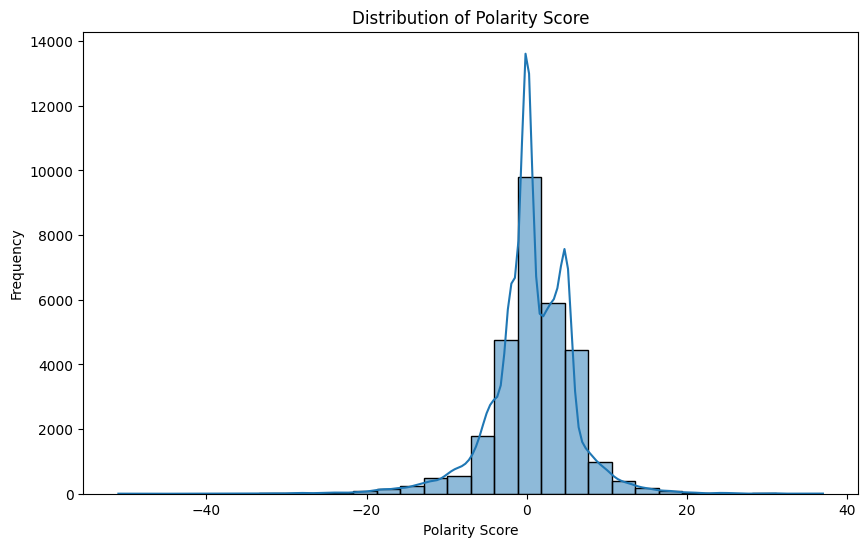

In [ ]:
# Menampilkan distribusi polarity_score dengan histogram
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=30, kde=True)
plt.title('Distribution of Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

Menampilkan diagram lingkaran untuk memudahkan visualisasi pembagian dataset.

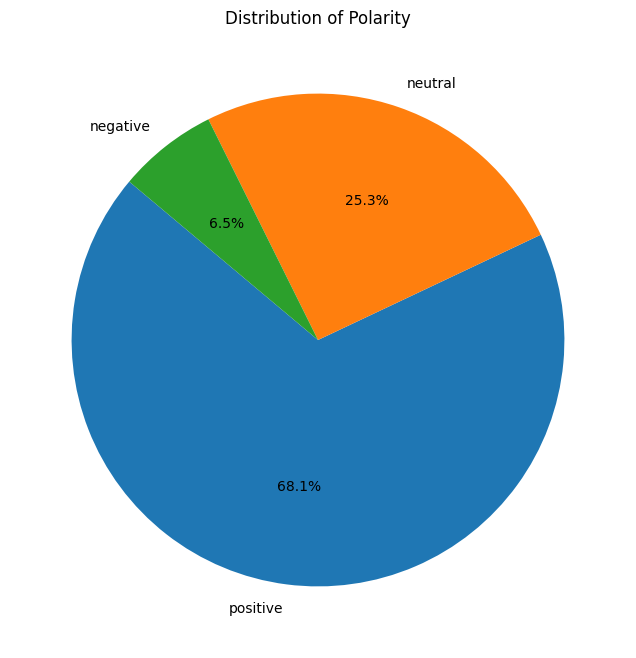

In [ ]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()

## Word cloud umum
Membuat wordcloud dari dataset tanpa melihat label.

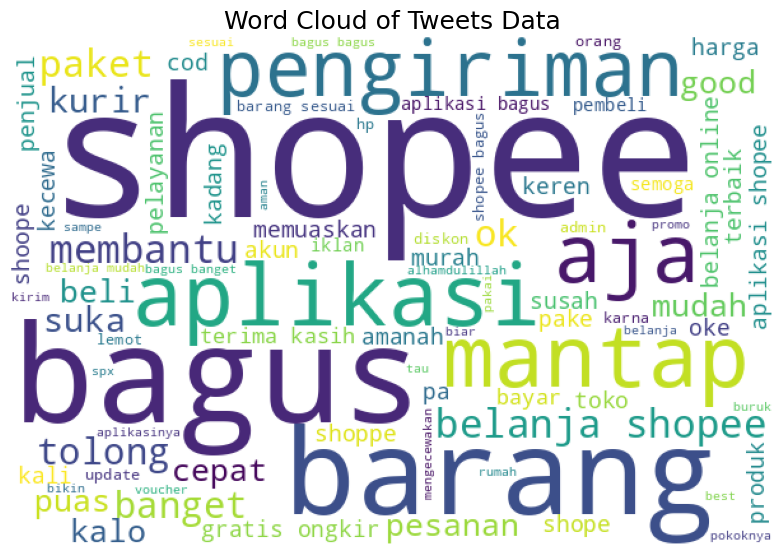

In [ ]:
# Membuat wordcloud secara umum

list_words = ''

for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

Word cloud positive

In [ ]:
# Membuat dataframe untuk wordcloud positive
pd.set_option('display.max_colwidth', 3000)

positive_tweets = clean_df[clean_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

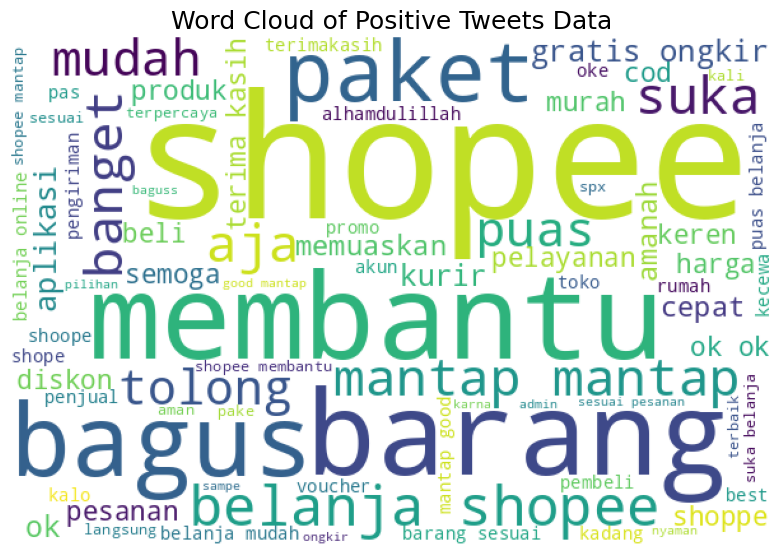

In [ ]:
# Menampilkan wordcloud untuk label positive
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

Word cloud negative

In [ ]:
# Membuat dataframe untuk wordcloud negative
pd.set_option('display.max_colwidth', 3000)

negative_tweets = clean_df[clean_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

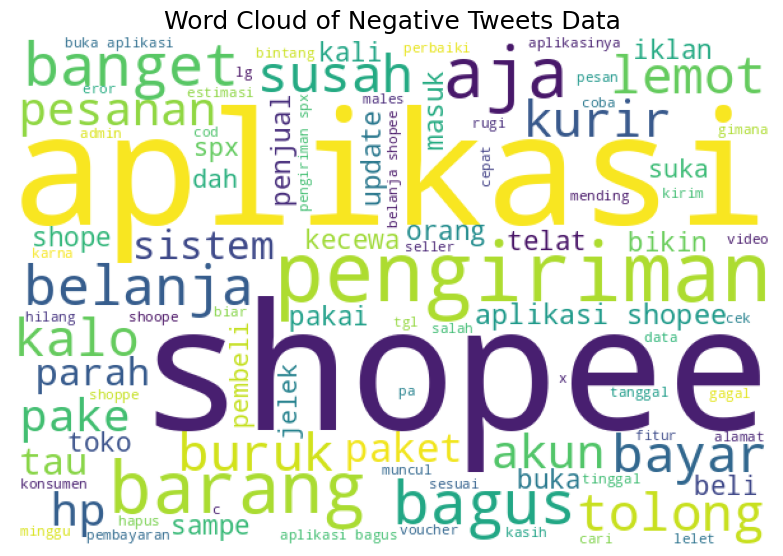

In [ ]:
# Menampilkan wordcloud untuk label negative
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

word cloud neutral

In [ ]:
# Membuat dataframe untuk wordcloud neutral
pd.set_option('display.max_colwidth', 3000)

neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

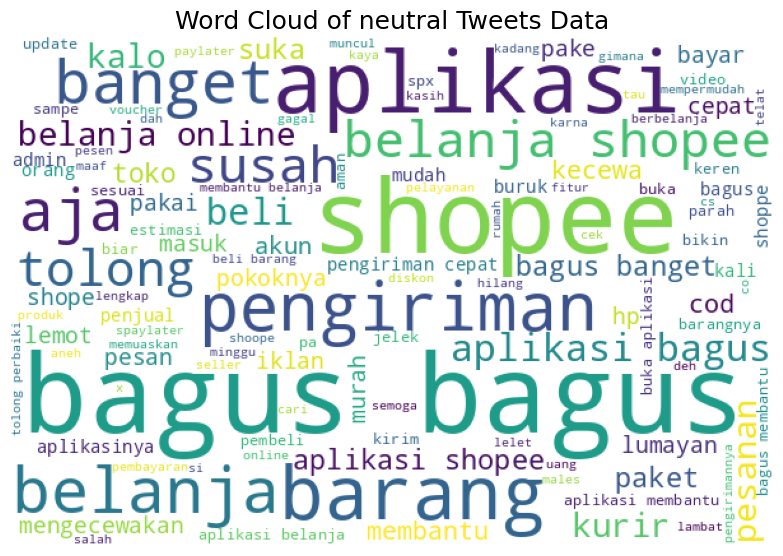

In [ ]:
# Menampilkan wordcloud untuk label neutral
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'neutral_tweets'.
for tweet in neutral_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of neutral Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

## Visualisasi dataset
Menampilkan distribusi dari panjang text.

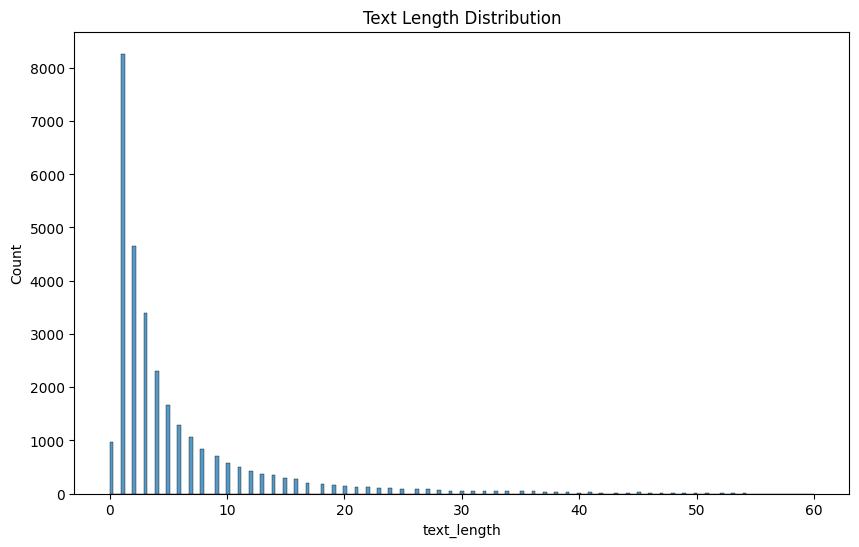

In [ ]:
plt.figure(figsize=(10, 6))

# Visualize text length distribution
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

Menampilkan kata yang paling sering muncul.


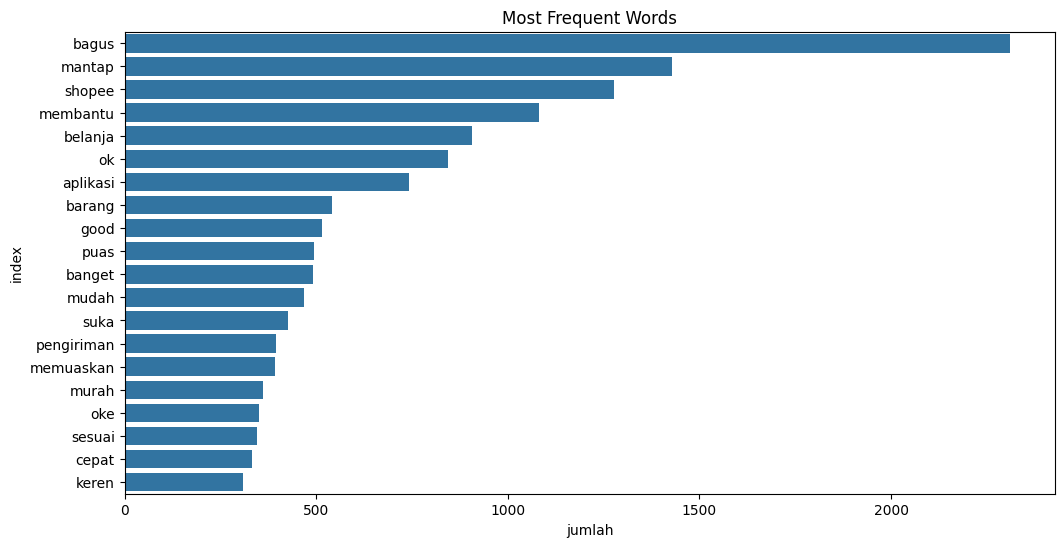

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

## Modeling
Pembuatan model dengan melakukan tiga percobaan skema pelatihan yang berbeda dan dibedakan dengan variasi dari dua kombinasi seperti berikut:

- Model 1
  - Algoritma Pelatihan: LSTM
  - Pembagian Data: Training 70, val 20, test 10
- Model 2
  - Algoritma Pelatihan: CNN
  - Pembagian Data: Training 80, val 10, test 10
- Model 3
  - Algoritma Pelatihan: GRU
  - Pembagian Data: Training 90, val 5, test 5
  
Kolom text_akhir dijadikan sebagai fitur dan kolom polarity dijadikan sebagai target.

In [ ]:
# Mengambil kolom text_akhir dan polarity
X = clean_df['text_akhir']
y = clean_df['polarity']

Melakukan tokenisasi.

In [ ]:
# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

Mendefinisikan callbacks yang akan berhenti jika nilai akurasi pelatihan > 0.95.

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.92:
            print(f"\nVal accuracy telah melebihi 0.92, menghentikan pelatihan pada epoch {epoch+1}")
            self.model.stop_training = True
early_stopping = CustomCallback()

## Model 1 - LSTM

In [ ]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)


In [ ]:
# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_LSTM = model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_LSTM, y_val_LSTM))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 - 72s - 7s/step - accuracy: 0.6312 - loss: 5.3207 - val_accuracy: 0.6785 - val_loss: 4.3769
Epoch 2/50
11/11 - 64s - 6s/step - accuracy: 0.6816 - loss: 3.8659 - val_accuracy: 0.6785 - val_loss: 3.2238
Epoch 3/50
11/11 - 73s - 7s/step - accuracy: 0.6816 - loss: 2.8538 - val_accuracy: 0.6785 - val_loss: 2.3912
Epoch 4/50
11/11 - 72s - 7s/step - accuracy: 0.6820 - loss: 2.1278 - val_accuracy: 0.6805 - val_loss: 1.7876
Epoch 5/50
11/11 - 66s - 6s/step - accuracy: 0.7032 - loss: 1.5791 - val_accuracy: 0.7477 - val_loss: 1.2705
Epoch 6/50
11/11 - 87s - 8s/step - accuracy: 0.8081 - loss: 1.1173 - val_accuracy: 0.8483 - val_loss: 0.9093
Epoch 7/50
11/11 - 75s - 7s/step - accuracy: 0.8565 - loss: 0.8129 - val_accuracy: 0.8737 - val_loss: 0.6855
Epoch 8/50
11/11 - 57s - 5s/step - accuracy: 0.8816 - loss: 0.6137 - val_accuracy: 0.8880 - val_loss: 0.5465
Epoch 9/50
11/11 - 80s - 7s/step - accuracy: 0.9052 - loss: 0.4710 - val_accuracy: 0.9005 - val_loss: 0.4391
Epoch 10/50
11/11 - 55s - 5s/s

In [ ]:
# Evaluasi model
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test score: %.2f" % (score_LSTM))
print("Test accuracy: %.2f" % (acc_LSTM))

94/94 - 4s - 39ms/step - accuracy: 0.9173 - loss: 0.2994
Test score: 0.30
Test accuracy: 0.92


In [ ]:
model_LSTM.save('model_LSTM.h5')

## Model 2 - CNN

In [ ]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

In [ ]:
# Membangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_CNN.add(Conv1D(64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_CNN = model_CNN.fit(X_train_CNN, y_train_CNN, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_CNN, y_val_CNN))


Epoch 1/50
12/12 - 44s - 4s/step - accuracy: 0.6293 - loss: 0.8541 - val_accuracy: 0.6780 - val_loss: 0.7493
Epoch 2/50
12/12 - 40s - 3s/step - accuracy: 0.6800 - loss: 0.7398 - val_accuracy: 0.6890 - val_loss: 0.6590
Epoch 3/50
12/12 - 42s - 3s/step - accuracy: 0.7220 - loss: 0.6209 - val_accuracy: 0.8237 - val_loss: 0.4737
Epoch 4/50
12/12 - 82s - 7s/step - accuracy: 0.8263 - loss: 0.4401 - val_accuracy: 0.8647 - val_loss: 0.3383
Epoch 5/50
12/12 - 40s - 3s/step - accuracy: 0.8778 - loss: 0.3260 - val_accuracy: 0.8997 - val_loss: 0.2671
Epoch 6/50
12/12 - 41s - 3s/step - accuracy: 0.9116 - loss: 0.2481 - val_accuracy: 0.9140 - val_loss: 0.2239
Epoch 7/50

Val accuracy telah melebihi 0.92, menghentikan pelatihan pada epoch 7
12/12 - 41s - 3s/step - accuracy: 0.9348 - loss: 0.1900 - val_accuracy: 0.9210 - val_loss: 0.2078


In [ ]:
# Evaluasi model
score_CNN, acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2,batch_size=1028)
print("Test score: %.2f" % (score_CNN))
print("Test accuracy: %.2f" % (acc_CNN))

3/3 - 1s - 442ms/step - accuracy: 0.9183 - loss: 0.2046
Test score: 0.20
Test accuracy: 0.92


In [ ]:
model_CNN.save('model_CNN.h5')

## Model 3 - GRU

In [ ]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=0.0526, random_state=42)

In [ ]:
# Membangun model GRU
model_GRU = Sequential()
model_GRU.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(Bidirectional(GRU(64, return_sequences=True)))
model_GRU.add(Bidirectional(GRU(128, return_sequences=False)))
model_GRU.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(num_classes, activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 1028
history_GRU = model_GRU.fit(X_train_GRU, y_train_GRU, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_val_GRU, y_val_GRU),callbacks=[early_stopping])


Epoch 1/20
27/27 - 144s - 5s/step - accuracy: 0.6366 - loss: 2.8117 - val_accuracy: 0.7720 - val_loss: 2.0031
Epoch 2/20
27/27 - 140s - 5s/step - accuracy: 0.8157 - loss: 1.5884 - val_accuracy: 0.8613 - val_loss: 1.1760
Epoch 3/20
27/27 - 141s - 5s/step - accuracy: 0.9002 - loss: 0.9194 - val_accuracy: 0.9073 - val_loss: 0.7201
Epoch 4/20
27/27 - 141s - 5s/step - accuracy: 0.9366 - loss: 0.5591 - val_accuracy: 0.9140 - val_loss: 0.5008
Epoch 5/20

Val accuracy telah melebihi 0.92, menghentikan pelatihan pada epoch 5
27/27 - 131s - 5s/step - accuracy: 0.9520 - loss: 0.3691 - val_accuracy: 0.9213 - val_loss: 0.3950


In [ ]:
# Evaluasi model
score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print("Test score: %.2f" % (score_GRU))
print("Test accuracy: %.2f" % (acc_GRU))

47/47 - 3s - 56ms/step - accuracy: 0.9213 - loss: 0.3789
Test score: 0.38
Test accuracy: 0.92


In [ ]:
# Menyimpan model
model_GRU.save('model_GRU.h5')

# Evaluasi model

In [ ]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'GRU'],
    'Accuracy Train': [history_LSTM.history['accuracy'][-1], history_CNN.history['accuracy'][-1],history_GRU.history['accuracy'][-1]],
    'Accuracy Test': [acc_LSTM, acc_CNN,acc_GRU]
})
results_df

,Model,Accuracy Train,Accuracy Test
0,LSTM,0.940333,0.917333
1,CNN,0.934750,0.918333
2,GRU,0.952037,0.921333


# Predict

In [ ]:
# Contoh data baru
new_texts = [
    "pemakai shopee temukan penjual barang bagus penjual berkualitas original pakaian gadget sparepart sepeda motor sedih fitur kurir rekomendasi gratis ongkos kirim bikin paket layanan berbayar murah gratisan bagus dunia harap shopee bikin promo gimmick bikin customer pindah app miss shopee",
    "kurir sicepat ganti nama si lambat si lambat shopee bagus langganan pke aplikasi shopee bawa nama jelek kurir sicepat min tolong kasih peringatan sicepat nakal kurirnya ngirimnya lambaaaaattttt kali",
    "saran belanja kurir rekomendasi pengirimannya komplain alasannya follow perkembangansaran free ongkos kirim pakai salah kurir kurir kurir"
]

# Nilai asli dari teks
true_labels = ["positive", "negative", "neutral"]

# Tokenisasi teks baru
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=X.shape[1])

# Membuat prediksi
predictions_LSTM = model_LSTM.predict(new_padded_sequences)
predictions_CNN = model_CNN.predict(new_padded_sequences)
predictions_GRU = model_GRU.predict(new_padded_sequences)

# Mengubah prediksi menjadi label
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)

predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)

# Menampilkan hasil prediksi
for text, true_label, label_LSTM, label_CNN, label_GRU in zip(new_texts, true_labels, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU):
    print(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label (LSTM): {label_LSTM}\nPredicted Label (CNN): {label_CNN}\nPredicted Label (GRU): {label_GRU}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Text: pemakai shopee temukan penjual barang bagus penjual berkualitas original pakaian gadget sparepart sepeda motor sedih fitur kurir rekomendasi gratis ongkos kirim bikin paket layanan berbayar murah gratisan bagus dunia harap shopee bikin promo gimmick bikin customer pindah app miss shopee
True Label: positive
Predicted Label (LSTM): positive
Predicted Label (CNN): positive
Predicted Label (GRU): positive

Text: kurir sicepat ganti nama si lambat si lambat shopee bagus langganan pke aplikasi shopee bawa nama jelek kurir sicepat min tolong kasih peringatan sicepat nakal kurirnya ngirimnya lambaaaaattttt kali
True Label: negative
Predicted Label (LSTM): negative
Predicted Label (CNN): negative
Predicted Label (GRU): negative

Text: saran belanja kurir rekomendasi pengirimannya komplain alasannya follow perkembangansaran free ongkos kirim pakai salah kurir kurir kurir
True 